In [1]:
# Loading Data

%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

data_pos = final_data[final_data['Score'] == 'positive'].sample(n=150)
data_neg = final_data[final_data['Score'] == 'negative'].sample(n=150)
final_150 = pd.concat([data_pos, data_neg])
score_150 = final_150['Score']

In [2]:
# BOW 
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final_150['CleanedText'].values)

In [3]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [4]:
final_counts.get_shape()

(300, 2321)

In [5]:
count_vect = CountVectorizer(ngram_range=(1, 2))
final_bigram_counts = count_vect.fit_transform(final_150['CleanedText'].values)

In [6]:
final_bigram_counts.get_shape()

(300, 11887)

In [7]:
from sklearn.preprocessing import StandardScaler
std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
std_data.shape

/usr/local/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(300, 11887)

In [8]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [9]:
std_data = std_data.todense()

In [10]:
type(std_data)

numpy.matrixlib.defmatrix.matrix

In [11]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter = 5000)
tsne_data = model.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T, score_150)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "Score"))

/usr/local/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


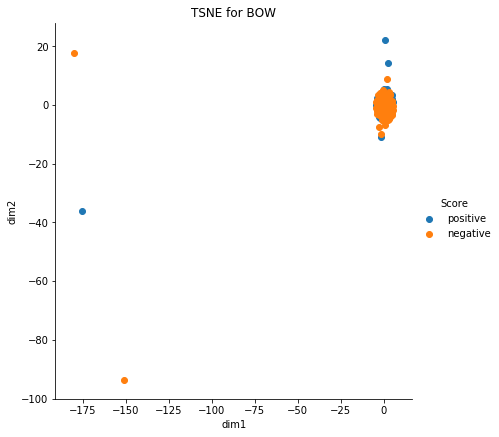

In [13]:
sns.FacetGrid(tsne_df, hue="Score", size = 6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for BOW")
plt.show()

In [15]:
#Observation:- Here, we are unable to simply draw a hyperplane and separate +ve and -ve reviews because it overlap each other. But we will have some alternative way to separates review

In [16]:
# TF_IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_150['CleanedText'].values)

In [17]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(final_tf_idf)

In [18]:
std_data = std_data.todense()

In [19]:
std_data.shape

(300, 11887)

/usr/local/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


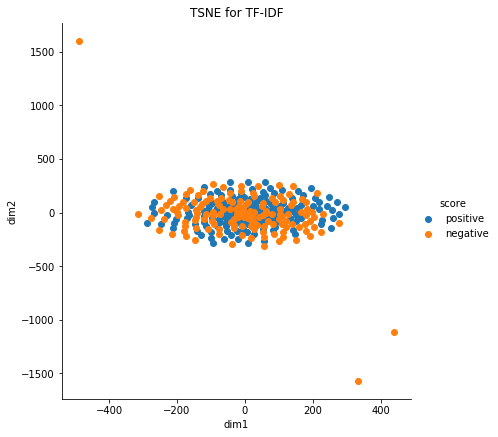

In [20]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 50)
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, score_150)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

In [21]:
## Observations:- As this representation also looks like bow and massively 
#overlapped +ve and -ve review.

In [24]:
'''Conclusions:-

AS none of TSNE representation gives a well separated both +ve and -ve reviews. </br>
We can not simply draw a plane to separate -ve and +ve reviews. Although, By looking at only visual representation of data we can not take decision whether to draw a plane or not.
We will have some alternative method by that we will look at into this problem like how we can separate -ve and +ve reviews.'''

'Conclusions:-\n\nAS none of TSNE representation gives a well separated both +ve and -ve reviews. </br>\nWe can not simply draw a plane to separate -ve and +ve reviews. Although, By looking at only visual representation of data we can not take decision whether to draw a plane or not.\nWe will have some alternative method by that we will look at into this problem like how we can separate -ve and +ve reviews.'

In [30]:
#Word2Vect

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
# Train own Word2Vec model using our text corpus
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i = 0
list_of_sent = []
for sent in final_150['Text'].values:
    filtered_sentences = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentences.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentences)

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 2
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
# To replace nan with 0 and inf with large finite number

sent_vectors = np.nan_to_num(sent_vectors)

300
50


/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


/usr/local/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


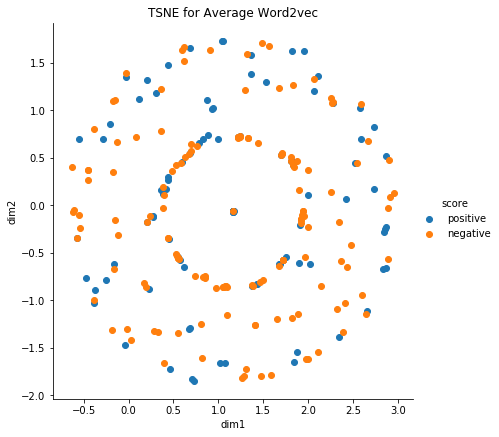

In [35]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 20, n_iter = 5000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_150)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

In [36]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
# To replace nan with 0 and inf with large finite number

tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)
    

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


/usr/local/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


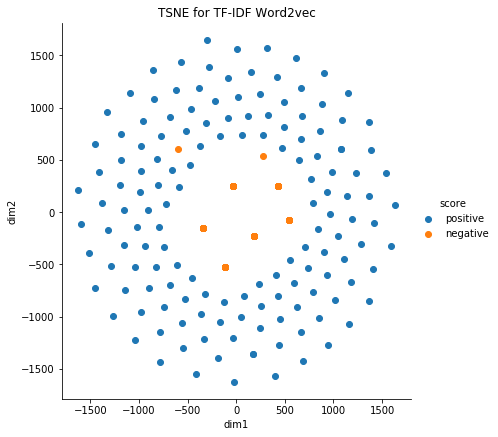

In [37]:
#tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_150)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF Word2vec")
plt.show()

In [38]:
'''
Observation- This plot also looks like the bow, tfidf and avg word2vec.Both +ve and -ve reviwes are not well seperated they overlapped each other.'''

'\nObservation- This plot also looks like the bow, tfidf and avg word2vec.Both +ve and -ve reviwes are not well seperated they overlapped each other.'